In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt
from torchviz import make_dot, make_dot_from_trace
%matplotlib inline

In [27]:
# Returns a training set loader
def train_set(batch_size_train):
    train_loader = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])), batch_size=batch_size_train, shuffle=True)
    return train_loader

#Returns a test set loader    
def test_set(batch_size_test):
    test_loader = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))])),batch_size=batch_size_test, shuffle=True)

    return test_loader
    
# Function to train the models and also used to display losses,counters, and epoch of training 
def train(network, optimizer, train_loader,train_losses, train_counter, log_interval, epoch): 
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(),"model.pth.tar" )
            torch.save(optimizer.state_dict(),"optimizer.pth.tar" )

#Function to test te network model and show accuracy after each epoch           
def test(network, test_loader, test_losses):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
#Function to plot the ground truths for Task 1A
def plot_truths(example_data, example_targets):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(example_data[i][0], cmap = 'gray', interpolation = 'none')
        plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])

#Function that utilized a library called torchviz to build a diagram of the network and save to the files        
def build_diagram(model):
    x = torch.randn(100,1,20,20)
    model_x = model(x)
    make_dot(model_x,params=dict(list(model.named_parameters()))).render("rnn_torchviz",format='png')
 
#Function that plots the accuracy scores and plotting the training and testing accuracy in a graph
def plot_accScores(train_counter,train_losses,test_counter,test_losses):
    fig = plt.figure()
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')

    

In [28]:
class MyNet(nn.Module):
    #two conv filter(5x5 kerenels), dropout 50%, two linear layers, and a flatten layer
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.flatten = nn.Flatten()
        self.fc2 = nn.Linear(50, 10)
        
    #feeds input in defined layers ad applies operations to the layer output
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(F.dropout(self.conv2(x)), 2),0.5)
        x = x.view(-1, 320)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x)

In [29]:
#Main function that displays tasks 1A-1E
def main():
    n_epochs = 5
    batch_train = 32
    batch_test = 1000
    learning_rate = 0.01
    momentum = 0.5
    log_interval = 10

    torch.backends.cudnn.enabled = False
    torch.manual_seed(42)
    train_loader = train_set(batch_train)
    test_loader = test_set(batch_test)
    
    examples = enumerate(test_loader)
    batch_idx, (example_data,example_targets)=next(examples)
    
    
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

    network = MyNet()
    optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
    #Task 1A: GetMNIST
    print("Task 1A: Print first 6 Examples")
    plot_truths(example_data,example_targets)
    
    #Task 1C: Build netowrk model diagram
    print("Task 1C: Save Diagram of Network")
    build_diagram(network)
    
    #task 1D and 1E: Training the model and saving the model
    print("Task 1D: Training Model and Saving")
    test(network, test_loader, test_losses)
    for epoch in range(1, n_epochs+1):
        train(network, optimizer, train_loader,train_losses, train_counter, log_interval, epoch)
        test(network, test_loader, test_losses)
    plot_accScores(train_counter,train_losses,test_counter,test_losses)
    

Task 1A: Print first 6 Examples
Task 1C: Save Diagram of Network
Task 1D: Training Model and Saving


<ipython-input-28-4d4d4311114c>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.2907, Accuracy: 1017/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.275563
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.286963
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.194209
Train Epoch: 1 [960/60000 (2%)]	Loss: 2.151917
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.054119
Train Epoch: 1 [1600/60000 (3%)]	Loss: 1.644993
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.405322
Train Epoch: 1 [2240/60000 (4%)]	Loss: 1.197177
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.908650
Train Epoch: 1 [2880/60000 (5%)]	Loss: 0.953006
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.669407
Train Epoch: 1 [3520/60000 (6%)]	Loss: 0.858059
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.635548
Train Epoch: 1 [4160/60000 (7%)]	Loss: 0.409476
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.779920
Train Epoch: 1 [4800/60000 (8%)]	Loss: 0.442383
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.568588
Train Epoch: 1 [5440/60000 (9%)]	Loss: 0.738305
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.737625
Train Epoch: 1 [6080/60000 (10%)]	L

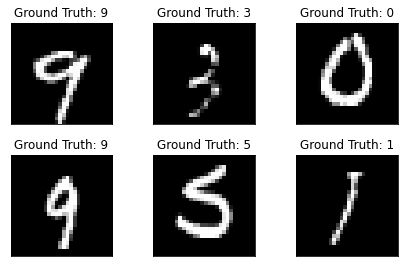

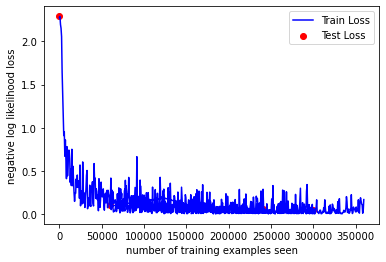

In [30]:
if __name__== "__main__":
    main()